This code is for learning MCMC, comparison between data and theory
following the instruction of https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

Starting with Bayesian theorem, given data, the probability of our model (posterior probability) is
\begin{align}
        \begin{split}
            P(model|data) = \frac{P(data|model) P(model)}{P(data)}.
        \end{split}
    \end{align}
    
Or we can rewrite it as
     \begin{align}
        \begin{split}
            P(\theta|D) = \frac{P(D|\theta) P(\theta)}{P(D)}.
        \end{split}
    \end{align}
    
where
- $ P(model|data)$ is "posterior" probability, given data

- $P(data|model)$ is "likelihood", the probability of getting these data, given this model

- $P(model)$ is "prior", the probability of this model

- $P(data)$ is "evidence", the probability of data


Some definitions/concepts:
    
- "MCMCs are a class of methods that most broadly are used to numerically perform multidimensional integrals. However, it is fully true that these methods are highly useful for the practice of inference; that is, fitting models to data." 

- "MCMC allows us to obtain better, more robust uncertainties on your parameters, to understand multi-modalities or covariances in your data, and marginalize out nuisance parameters that you don’t care about, but nevertheless need to include in your modeling to obtain accurate results."

- "The fundamental process of running an MCMC: to compare generated models against data. Those models are generated by a set of parameters, and our goal: to sample from the set of parameters that produces the models that well-fit our data."

- MCMC allow us to estimate the posterior distribution (LHS) by numerically integrating the RHS, for some given expectation value

\begin{align}
    E(\theta) = \int \theta p(\theta) d\theta \approx \frac{1}{N} \sum_i^N \theta_i,
\end{align}

or for any function of $\theta$

\begin{align}
    E(g(\theta)) = \int g(\theta) p(\theta) d\theta,
\end{align}

In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
import emcee

In [62]:
import corner

In [63]:
import astropy.io.fits as fits

In [64]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [65]:
N_GC = data['NGCs']
Mag_z = data['Mag z']

In [66]:
err_GC = data['err GC']

print(err_GC)

In [79]:
a = np.flatnonzero(N_GC != 0)

In [80]:
print(a)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [82]:
N_GC = N_GC[a]
Mag_z = Mag_z[a]
err_GC = err_GC[a]

In [84]:
logerr_GC = np.log10(err_GC)

In [85]:
logN_GC = np.log10(N_GC)

<ErrorbarContainer object of 3 artists>

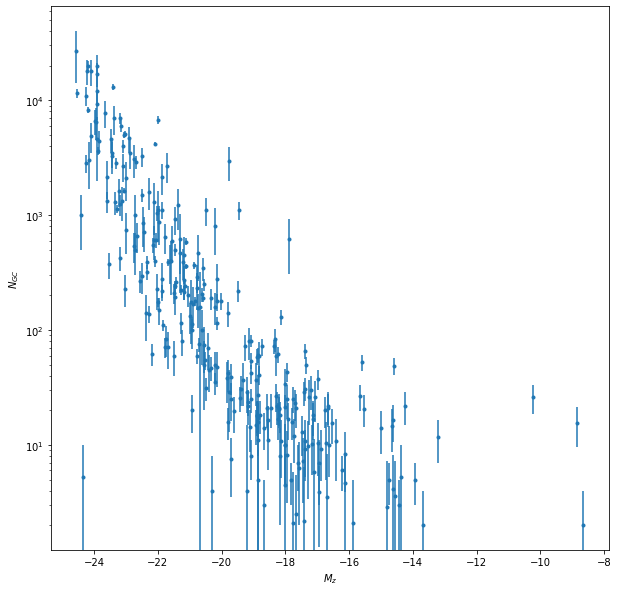

In [86]:
plt.figure(figsize=(10,10))
plt.xlabel('$M_z$')
plt.ylabel('$N_{GC}$')
plt.yscale('log')
#plt.ylim(0,100)
plt.errorbar(Mag_z,N_GC,yerr=err_GC,fmt='.')

The simplest fitting model could be

$ y(x) = ax+b$

where x, y are magnitude and number of GCs, respectively; a, b are parameters.

In [87]:
def model(para, mag=Mag_z): #para = all parameters in the model, mag = x axis
    a, b = para 
    model = a*mag + b
    return model

 a, b = para define a function that return how good a fit our model is to the data, for the given set of parameters, weighted by the error in the data points (simple $\chi^2$ type check). 

\begin{align}
    L_{lnlike} = -0.5\sum (\frac{y-y_{model}}{y_{err}})^2
\end{align}

- If the new model returns better fit compare to the default model (by an acceptance ratio), the walker will move toward that and repeat the process.

- Every walker keeps a record of $\theta$ and the likelihood of the model given data at value $\theta$.

- As if MCMC runs long enough to converge, it represents a sample of reasonable models to describe the data;



In [88]:
def lnlike(para, mag, y, yerr):
    lnlike = -0.5*np.sum(((y-model(para,mag))/yerr)**2)
    return lnlike

In [89]:
# the things we know (fact/conditions to the parameters)
def lnprior(para):
    a, b = para 
    if -1 < a < 1 and -10 < b < 0:   #inside the fact region log(prior) = 0 <=> prior = 1; elsewhere prior = 0, log = -\inf
         return 0.0
    else:
        return -np.inf

In [90]:
# the function as lnprior output + lnlike output
def lnprob(para, mag, y, yerr):
    lp = lnprior(para)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(para, mag, y, yerr)

In [91]:
data     = (Mag_z, logN_GC, logerr_GC)
nwalkers = 200
niter    = 500
initial  = np.array([-0.5, -8]) # initial set of values of the parameters (guess)
ndim     = len(initial)

#stepping from one place to the next, generate N-dimensional parameters space close to the current location
p0       = [np.array(initial) + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

In [92]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)  #initial position of parameters
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [93]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


ValueError: Probability function returned NaN

In [94]:
def plotter(sampler,mag=Mag_z, N=N_GC):
    plt.ion()
    plt.figure(figsize=(10,10))
    plt.yscale("log")
    plt.errorbar(Mag_z,N, yerr = err_GC,fmt='.',label='NGC vs mag z')
    samples = sampler.flatchain
    for para in samples[np.random.randint(len(samples), size=300)]:
        plt.plot(Mag_z, 10**model(para, Mag_z),'.', color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('$M_z$')
    plt.ylabel('$N_{GC}$')
    plt.legend()
    plt.show()

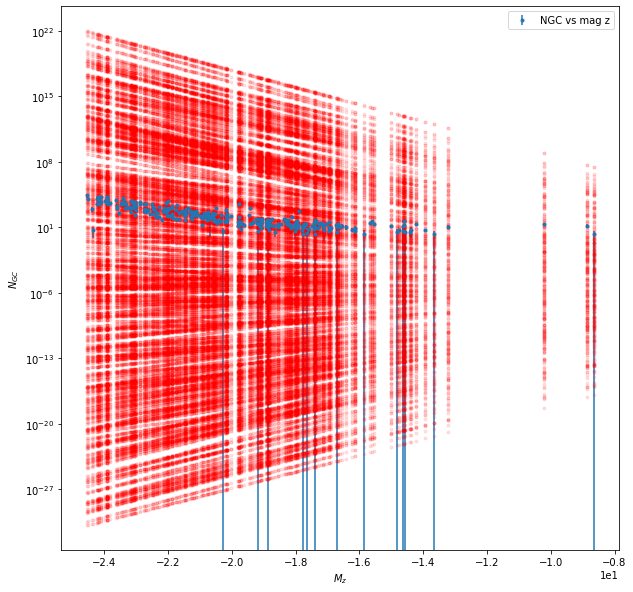

In [95]:
plotter(sampler)

In [96]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
#value of each parameter, highest likelihood model 

array([-0.4478212 , -7.70156081])

In [97]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max,Mag_z)
plt.figure(figsize=(10,10))
plt.errorbar(Mag_z,N_GC,yerr=err,fmt='.')
plt.plot(Mag_z,10**best_fit_model,'.',label='Highest Likelihood Model')
plt.yscale("log")
plt.show()
print ('para max: ',theta_max)

NameError: name 'err' is not defined

<Figure size 720x720 with 0 Axes>

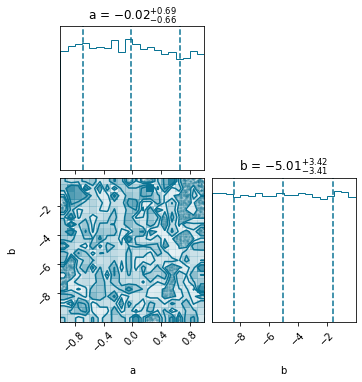

In [98]:
#posterior spread
labels = ['a' ,'b']
fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])